In [1]:
# Зависимости
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [2]:
# Инициализируем все известные генераторы случаынйх чисел / Setting all known random seeds
my_code = "Sevastyanov"
seed_limit = 2 ** 32
my_seed = int.from_bytes(my_code.encode(), "little") % seed_limit

os.environ['PYTHONHASHSEED']=str(my_seed)

random.seed(my_seed)

np.random.seed(my_seed)

tf.compat.v1.set_random_seed(my_seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# Читаем данные из файла
train_data = pd.read_csv("datasets/iris_train.csv")

In [4]:
train_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.7,2.6,3.5,1.0,Iris-versicolor
1,5.1,3.8,1.5,0.3,Iris-setosa
2,5.4,3.9,1.3,0.4,Iris-setosa
3,6.5,3.0,5.2,2.0,Iris-virginica
4,6.9,3.1,4.9,1.5,Iris-versicolor


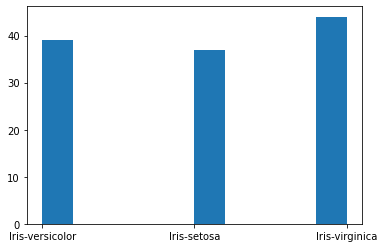

In [5]:
classes = train_data['species']
plt.hist(classes)
plt.show()

In [5]:
# Определим размер валидационной выборки
val_size = round(0.2*len(train_data))
print(val_size)

24


In [6]:
# Создадим обучающую и валидационную выборки
random_state = my_seed
train, val = train_test_split(train_data, test_size=val_size, random_state=random_state)
print(len(train), len(val))

96 24


In [7]:
# Значения в числовых столбцах преобразуем к отрезку [0,1].
# Для настройки скалировщика используем только обучающую выборку.
num_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
ord_columns = ['species']

ct = ColumnTransformer(transformers=[('numerical', MinMaxScaler(), num_columns)], remainder='passthrough')

ct.fit(train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['sepal_length', 'sepal_width', 'petal_length',
                                  'petal_width'])])

In [8]:
# Преобразуем значения, тип данных приводим к DataFrame
sc_train = pd.DataFrame(ct.transform(train))
sc_val = pd.DataFrame(ct.transform(val))

In [9]:
# Устанавливаем названия столбцов
column_names = num_columns + ord_columns
sc_train.columns = column_names
sc_val.columns = column_names

In [10]:
sc_train

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.485714,0.416667,0.661017,0.708333,Iris-virginica
1,0.714286,0.458333,0.745763,0.833333,Iris-virginica
2,0.342857,0.333333,0.661017,0.791667,Iris-virginica
3,0.942857,0.75,0.966102,0.875,Iris-virginica
4,0.8,0.666667,0.864407,1,Iris-virginica
...,...,...,...,...,...
91,0.2,0.75,0.101695,0.0416667,Iris-setosa
92,0.0571429,0.5,0.0677966,0.0416667,Iris-setosa
93,0.4,0.333333,0.694915,0.958333,Iris-virginica
94,0.371429,0.75,0.118644,0.0833333,Iris-setosa


In [11]:
# Отберем необходимые параметры
x_train = sc_train[num_columns]
x_val = sc_val[num_columns]

y_train = (sc_train[ord_columns].values).flatten()
y_val = (sc_val[ord_columns].values).flatten()

In [12]:
# Создадим простую модель логистической регрессии
model = LogisticRegression()

In [13]:
# Обучим модель
model.fit(x_train, y_train)

LogisticRegression()

In [14]:
# Проверим работу обученной нейронной сети на валидационной выборке
pred_val = model.predict(x_val)
f1 = f1_score(y_val, pred_val, average='weighted')
print(f1)

0.7331309041835357


In [15]:
test = pd.read_csv("datasets/iris_test.csv")

In [17]:
test['species'] = ''

In [18]:
test.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.4,3.7,1.5,0.2,
1,6.0,3.4,4.5,1.6,
2,5.9,3.0,4.2,1.5,
3,5.7,3.0,4.2,1.2,
4,5.6,2.7,4.2,1.3,


In [19]:
sc_test = pd.DataFrame(ct.transform(test))
sc_test.columns = column_names

In [20]:
x_test = sc_test[num_columns]

In [21]:
test['species'] = model.predict(x_test)

In [22]:
test.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.4,3.7,1.5,0.2,Iris-setosa
1,6.0,3.4,4.5,1.6,Iris-virginica
2,5.9,3.0,4.2,1.5,Iris-virginica
3,5.7,3.0,4.2,1.2,Iris-versicolor
4,5.6,2.7,4.2,1.3,Iris-versicolor


In [23]:
test.to_csv('task4_results/iris_test_result.csv', index=False)